In [1]:
# Use DeepSurv from the repo
import sys
sys.path.append('../deepsurv')
import deep_surv

from deep_surv import load_model_from_json
from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


--------------------------------------------------------------------------
The library attempted to open the following supporting CUDA libraries,
but each of them failed.  CUDA-aware support is disabled.
libcuda.so.1: cannot open shared object file: No such file or directory
libcuda.dylib: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.so.1: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.dylib: cannot open shared object file: No such file or directory
If you are not interested in CUDA-aware support, then run with
--mca mpi_cuda_support 0 to suppress this message.  If you are interested
in CUDA-aware support, then try setting LD_LIBRARY_PATH to the location
of libcuda.so.1 to get passed this issue.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a spec

In [2]:
import h5py

# Read in dataset
First, I read in the dataset and print the first five elements to get a sense of what the dataset looks like

In [3]:
DATASET_DIR = '/data/scratch/jyu/DeepSurvival/data/'

In [4]:
class LoadData:
    """
    Loading preprocessed data from .h5 file.
    Has to be similar to saving data function in data processing notebook.
    (Same names for datasets etc.)
    
    """
    def __init__(self, name):
        dataset_file = name+'.h5'
        
        f = h5py.File(DATASET_DIR+dataset_file, 'r')
#         f = h5py.File('/home/gennadyr/IPython/tests_john/version_age_3/models/'+dataset_file, 'r')
        
        self.fraction_train = f['fraction_train'][:]
        self.fraction_validation = f['fraction_validation'][:]
        self.fraction_test = f['fraction_test'][:]

        self.train_MRI_data = f['train_MRI_data'][:]
        self.validation_MRI_data = f['validation_MRI_data'][:]
        self.test_MRI_data = f['test_MRI_data'][:]
        
        gene_columns = f['gene_column_names'][:]
        
        train_gene_data = f['train_gene_data'][:]
        validation_gene_data = f['validation_gene_data'][:]
        test_gene_data = f['test_gene_data'][:]
        
        self.train_gene_data = pd.DataFrame(train_gene_data, columns=gene_columns)
        self.validation_gene_data = pd.DataFrame(validation_gene_data, columns=gene_columns)
        self.test_gene_data = pd.DataFrame(test_gene_data, columns=gene_columns)
        
        train_label_data1 = f['train_label_data1'][:]
        train_label_data2 = f['train_label_data2'][:]
        validation_label_data1 = f['validation_label_data1'][:]
        validation_label_data2 = f['validation_label_data2'][:]
        test_label_data1 = f['test_label_data1'][:]
        test_label_data2 = f['test_label_data2'][:]
        
        columns = f['label_column_names'][:]
        
        train_label_data2 = pd.DataFrame(train_label_data2)
        train_label_data2.columns = columns
        validation_label_data2 = pd.DataFrame(validation_label_data2)
        validation_label_data2.columns = columns
        test_label_data2 = pd.DataFrame(test_label_data2)
        test_label_data2.columns = columns
        
        train_label_data2['bigrfullname'] = train_label_data1
        validation_label_data2['bigrfullname'] = validation_label_data1
        test_label_data2['bigrfullname'] = test_label_data1

        self.train_label_data = train_label_data2
        self.validation_label_data = validation_label_data2
        self.test_label_data = test_label_data2

        f.close()

        print('Loaded datasets from '+DATASET_DIR+dataset_file)

# Transform the dataset to "DeepSurv" format
DeepSurv expects a dataset to be in the form:

    {
        'x': numpy array of float32
        'e': numpy array of int32
        't': numpy array of float32
        'hr': (optional) numpy array of float32
    }
    
You are providing me a csv, which I read in as a pandas dataframe. Then I convert the pandas dataframe into the DeepSurv dataset format above. 

In [5]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'dementia', time_col = 'event_time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col, 'ergoid'], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset


[rad-hpc-master-001:28016] 2 more processes have sent help message help-mpi-btl-openib-cpc-base.txt / no cpcs for port
[rad-hpc-master-001:28016] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


In [6]:
np.random.seed(42)

[rad-hpc-master-001:27627] 2 more processes have sent help message help-mpi-btl-openib-cpc-base.txt / no cpcs for port
[rad-hpc-master-001:27627] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


Now once you have your dataset all formatted, define you hyper_parameters as a Python dictionary. 
I'll provide you with some example hyper-parameters, but you should replace the values once you tune them to your specific dataset

Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
2025-08-31 18:44:41,393 - Training step 0/1000    |                         | - loss: 22.4907 - ci: 0.5469
2025-08-31 18:44:41,393 - Training step 0/1000    |                         | - loss: 22.4907 - ci: 0.5469
2025-08-31 18:45:35,988 - Training step 250/1000  |******                   | - loss: 7.4471 - ci: 0.8459
2025-08-31 18:45:35,988 - Training step 250/1000  |******                   | - loss: 7.4471 - ci: 0.8459
2025-08-31 18:46:27,606 - Training step 500/1000  |************             | - loss: 7.3522 - ci: 0.8469
2025-08-31 18:46:27,606 - Training step 500/1000  |************             | - loss: 7.3522 - ci: 0.8469
2025-08-31 18:47:19,866 - Training step 750/1000  |******************       | - loss: 7.3254 - ci: 0.8490
2025-08-31 18:47:19,866 - Training step 750/1000  |******************       | - loss: 7.3254 - ci: 0.8490
2025-08-31 18:48:13,496 - Finished Training with 1000 iterations in

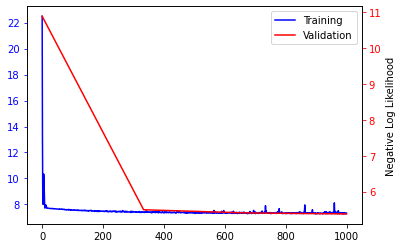

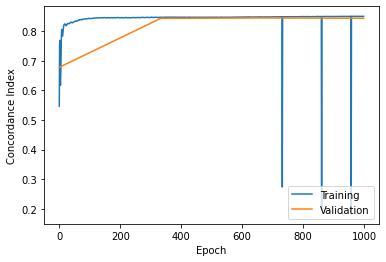

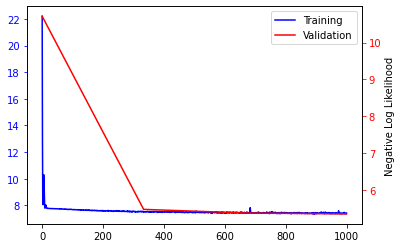

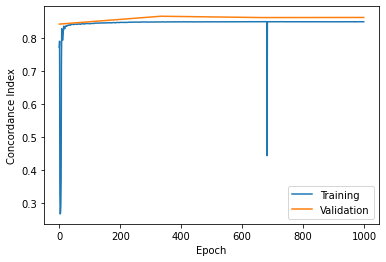

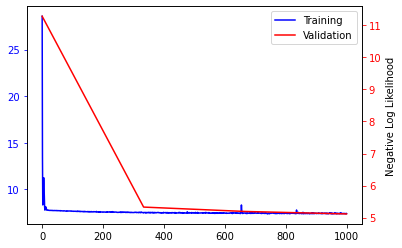

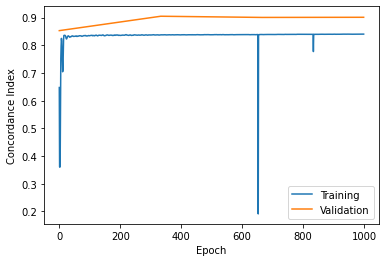

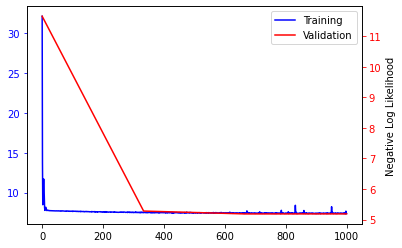

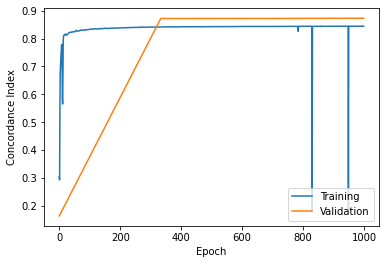

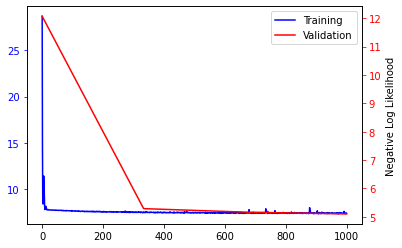

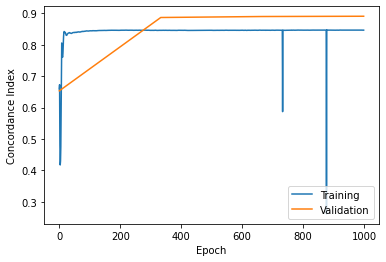

In [14]:
###image
c=[]

for i in range(1,6):
    data = LoadData('Total_fs_RS_cv_split_'+str(i))

    train_label_set=data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    columnsname=['TBV','HV','INF','age','PRS']
    mean=train_label_set[columnsname].mean()
    std=train_label_set[columnsname].std()
    train_label_set[columnsname]=(train_label_set[columnsname]-mean)/std
    train_label_set['WMH']=np.log(train_label_set['WMH'])
    train_label_set=train_label_set.iloc[:,:-3].drop('ApoE4',axis=1)



    validation_label_set=data.validation_label_data
    b=validation_label_set['bigrfullname'].str.decode("utf-8")
    validation_label_set['bigrfullname']=1
    validation_label_set['bigrfullname']=b
    validation_label_set = validation_label_set.set_index('bigrfullname')
    validation_label_set.columns=validation_label_set.columns.str.decode("utf-8")
    validation_label_set['ergoid']=validation_label_set['ergoid'].astype('int')
    
    validation_label_set[columnsname]=(validation_label_set[columnsname]-mean)/std
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])
    validation_label_set=validation_label_set.iloc[:,:-3].drop('ApoE4',axis=1)



    train_data = dataframe_to_deepsurv_ds(train_label_set, event_col = 'dementia', time_col= 'event_time')
    valid_data = dataframe_to_deepsurv_ds(validation_label_set, event_col = 'dementia', time_col= 'event_time')
    
    hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-02,
    'lr_decay': 0.1,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
    }
        
    # Create an instance of DeepSurv using the hyperparams defined above
    model = deep_surv.DeepSurv(**hyperparams)

    # DeepSurv can now leverage TensorBoard to monitor training and validation
    # This section of code is optional. If you don't want to use the tensorboard logger
    # Uncomment the below line, and comment out the other three lines: 
    # logger = None
    
    experiment_name='model_BM_'+str(i)
    logdir = './logs/tensorboard/'
    logger = TensorboardLogger(experiment_name, logdir=logdir)

    # Now we train the model
    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    n_epochs = 1000

    # If you have validation data, you can add it as the second parameter to the function
    metrics = model.train(train_data,valid_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)
    viz.plot_log(metrics)

    test_label_set=data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')

    test_label_set[columnsname]=(test_label_set[columnsname]-mean)/std
    test_label_set['WMH']=np.log(test_label_set['WMH'])
    test_label_set=test_label_set.iloc[:,:-3].drop('ApoE4',axis=1)
    
    test_data = dataframe_to_deepsurv_ds(test_label_set, event_col = 'dementia', time_col= 'event_time')
    

    ci=model.get_concordance_index(**test_data)
    print(ci)
    c.append(ci)
    
    
    output_file = experiment_name +'_test_predictions.txt'
    with open('../final/'+output_file, "w") as f:
        for element in model.predict_risk(test_data['x']):
            f.write(str(element[0]) + "\n")
    f.close()


Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
2025-08-31 16:31:55,011 - Training step 0/1000    |                         | - loss: 28.6462 - ci: 0.3655
2025-08-31 16:32:50,831 - Training step 250/1000  |******                   | - loss: 7.4411 - ci: 0.8615
2025-08-31 16:33:43,235 - Training step 500/1000  |************             | - loss: 7.3971 - ci: 0.8626
2025-08-31 16:34:37,036 - Training step 750/1000  |******************       | - loss: 7.3034 - ci: 0.8636
2025-08-31 16:35:31,097 - Finished Training with 1000 iterations in 216.46s
0.8710506203554645
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
2025-08-31 16:35:33,879 - Training step 0/1000    |                         | - loss: 27.2393 - ci: 0.5609
2025-08-31 16:36:26,290 - Training step 250/1000  |******                   | - loss: 7.4699 - ci: 0.8516
2025-08-31 16:37:19,197 - Training step 500/1000  |************             | - loss: 7.4266 - ci: 0.

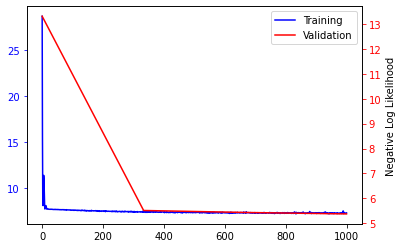

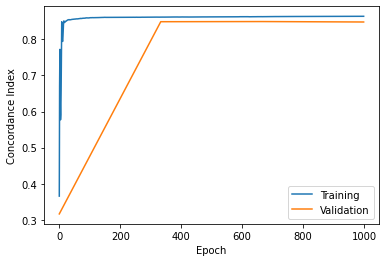

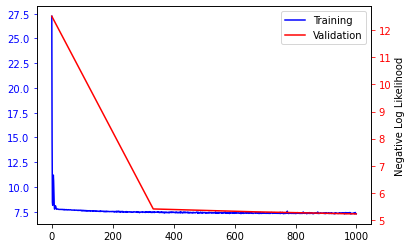

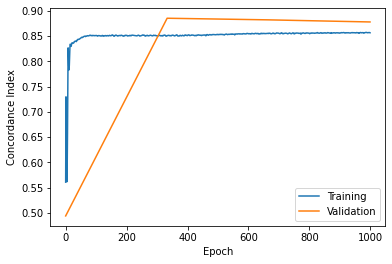

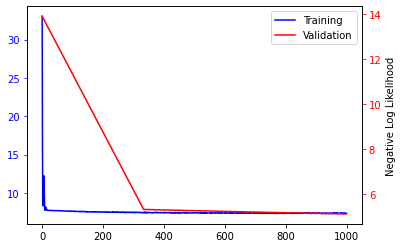

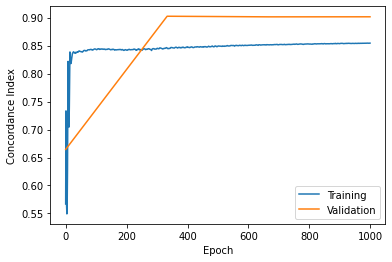

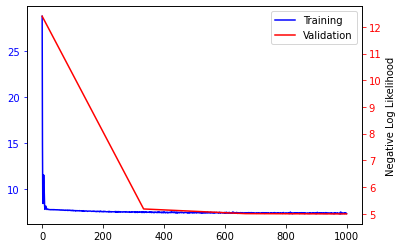

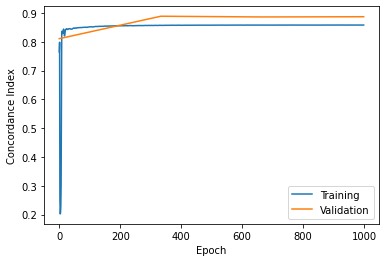

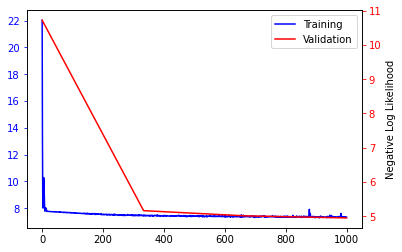

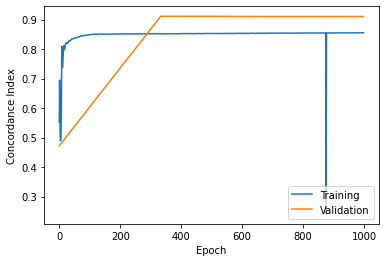

In [7]:
###Gender_Age
c=[]

for i in range(1,6):
    data = LoadData('Total_fs_RS_cv_split_'+str(i))

    train_label_set=data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    columnsname=['TBV','HV','INF','age','PRS']
    mean=train_label_set[columnsname].mean()
    std=train_label_set[columnsname].std()
    train_label_set[columnsname]=(train_label_set[columnsname]-mean)/std
    train_label_set['WMH']=np.log(train_label_set['WMH'])
    train_label_set=train_label_set.iloc[:,:-1].drop('ApoE4',axis=1)



    validation_label_set=data.validation_label_data
    b=validation_label_set['bigrfullname'].str.decode("utf-8")
    validation_label_set['bigrfullname']=1
    validation_label_set['bigrfullname']=b
    validation_label_set = validation_label_set.set_index('bigrfullname')
    validation_label_set.columns=validation_label_set.columns.str.decode("utf-8")
    validation_label_set['ergoid']=validation_label_set['ergoid'].astype('int')
    
    validation_label_set[columnsname]=(validation_label_set[columnsname]-mean)/std
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])
    validation_label_set=validation_label_set.iloc[:,:-1].drop('ApoE4',axis=1)



    train_data = dataframe_to_deepsurv_ds(train_label_set, event_col = 'dementia', time_col= 'event_time')
    valid_data = dataframe_to_deepsurv_ds(validation_label_set, event_col = 'dementia', time_col= 'event_time')
    
    hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-02,
    'lr_decay': 0.1,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
    }
        
    # Create an instance of DeepSurv using the hyperparams defined above
    model = deep_surv.DeepSurv(**hyperparams)

    # DeepSurv can now leverage TensorBoard to monitor training and validation
    # This section of code is optional. If you don't want to use the tensorboard logger
    # Uncomment the below line, and comment out the other three lines: 
    # logger = None
    
    experiment_name='model_Gender_Age_'+str(i)
    logdir = './logs/tensorboard/'
    logger = TensorboardLogger(experiment_name, logdir=logdir)

    # Now we train the model
    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    n_epochs = 1000

    # If you have validation data, you can add it as the second parameter to the function
    metrics = model.train(train_data,valid_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)
    viz.plot_log(metrics)

    test_label_set=data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')

    test_label_set[columnsname]=(test_label_set[columnsname]-mean)/std
    test_label_set['WMH']=np.log(test_label_set['WMH'])
    test_label_set=test_label_set.iloc[:,:-1].drop('ApoE4',axis=1)
    
    test_data = dataframe_to_deepsurv_ds(test_label_set, event_col = 'dementia', time_col= 'event_time')
    

    ci=model.get_concordance_index(**test_data)
    print(ci)
    c.append(ci)
    
    
    output_file = experiment_name +'_test_predictions.txt'
    with open('../final/'+output_file, "w") as f:
        for element in model.predict_risk(test_data['x']):
            f.write(str(element[0]) + "\n")
    f.close()


Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
2025-08-31 16:50:05,074 - Training step 0/1000    |                         | - loss: 27.9001 - ci: 0.6259
2025-08-31 16:50:58,681 - Training step 250/1000  |******                   | - loss: 7.3805 - ci: 0.8679
2025-08-31 16:51:51,990 - Training step 500/1000  |************             | - loss: 7.2468 - ci: 0.8689
2025-08-31 16:52:48,207 - Training step 750/1000  |******************       | - loss: 7.2988 - ci: 0.8705
2025-08-31 16:53:42,350 - Finished Training with 1000 iterations in 217.83s
0.8851813909621608
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
2025-08-31 16:53:45,946 - Training step 0/1000    |                         | - loss: 28.0765 - ci: 0.3268
2025-08-31 16:54:38,881 - Training step 250/1000  |******                   | - loss: 7.4772 - ci: 0.8682
2025-08-31 16:55:36,125 - Training step 500/1000  |************             | - loss: 7.4013 - ci: 0.

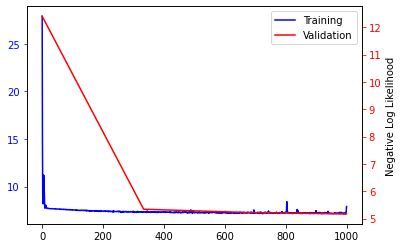

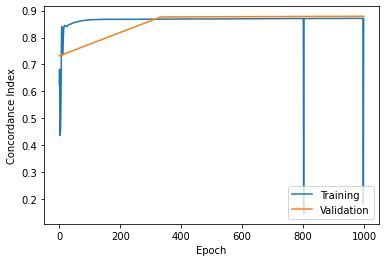

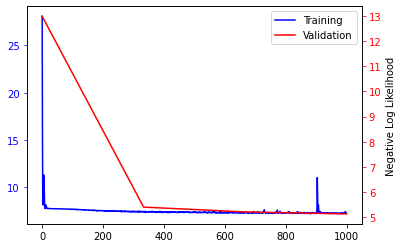

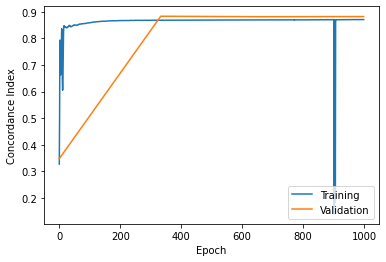

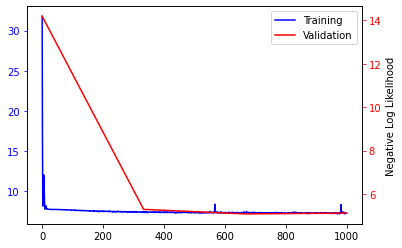

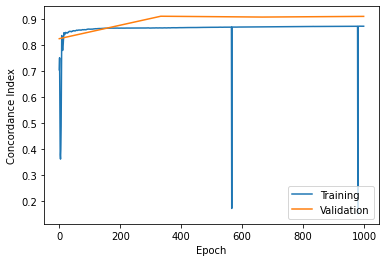

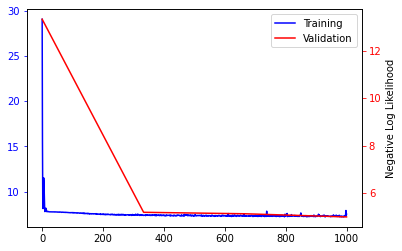

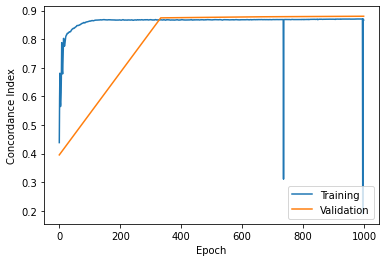

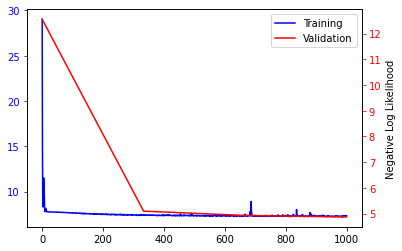

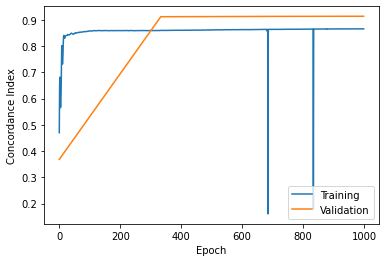

In [8]:
###Gender_Age_Apoe
c=[]

for i in range(1,6):
    data = LoadData('Total_fs_RS_cv_split_'+str(i))

    train_label_set=data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    columnsname=['TBV','HV','INF','age','PRS']
    mean=train_label_set[columnsname].mean()
    std=train_label_set[columnsname].std()
    train_label_set[columnsname]=(train_label_set[columnsname]-mean)/std
    train_label_set['WMH']=np.log(train_label_set['WMH'])
    train_label_set=train_label_set.iloc[:,:-1]



    validation_label_set=data.validation_label_data
    b=validation_label_set['bigrfullname'].str.decode("utf-8")
    validation_label_set['bigrfullname']=1
    validation_label_set['bigrfullname']=b
    validation_label_set = validation_label_set.set_index('bigrfullname')
    validation_label_set.columns=validation_label_set.columns.str.decode("utf-8")
    validation_label_set['ergoid']=validation_label_set['ergoid'].astype('int')
    
    validation_label_set[columnsname]=(validation_label_set[columnsname]-mean)/std
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])
    validation_label_set=validation_label_set.iloc[:,:-1]


    train_data = dataframe_to_deepsurv_ds(train_label_set, event_col = 'dementia', time_col= 'event_time')
    valid_data = dataframe_to_deepsurv_ds(validation_label_set, event_col = 'dementia', time_col= 'event_time')
    
    hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-02,
    'lr_decay': 0.1,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
    }
        
    # Create an instance of DeepSurv using the hyperparams defined above
    model = deep_surv.DeepSurv(**hyperparams)

    # DeepSurv can now leverage TensorBoard to monitor training and validation
    # This section of code is optional. If you don't want to use the tensorboard logger
    # Uncomment the below line, and comment out the other three lines: 
    # logger = None
    
    experiment_name='model_Gender_Age_Apoe_'+str(i)
    logdir = './logs/tensorboard/'
    logger = TensorboardLogger(experiment_name, logdir=logdir)

    # Now we train the model
    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    n_epochs = 1000

    # If you have validation data, you can add it as the second parameter to the function
    metrics = model.train(train_data,valid_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)
    viz.plot_log(metrics)

    test_label_set=data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
    test_label_set[columnsname]=(test_label_set[columnsname]-mean)/std
    test_label_set['WMH']=np.log(test_label_set['WMH'])
    test_label_set=test_label_set.iloc[:,:-1]
    
    test_data = dataframe_to_deepsurv_ds(test_label_set, event_col = 'dementia', time_col= 'event_time')
    

    ci=model.get_concordance_index(**test_data)
    print(ci)
    c.append(ci)
    
    
    output_file = experiment_name +'_test_predictions.txt'
    with open('../final/'+output_file, "w") as f:
        for element in model.predict_risk(test_data['x']):
            f.write(str(element[0]) + "\n")
    f.close()


Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
2025-08-31 17:08:32,279 - Training step 0/1000    |                         | - loss: 31.5969 - ci: 0.6384
2025-08-31 17:09:25,512 - Training step 250/1000  |******                   | - loss: 7.6106 - ci: 0.8742
2025-08-31 17:10:17,887 - Training step 500/1000  |************             | - loss: 7.2523 - ci: 0.8760
2025-08-31 17:11:13,659 - Training step 750/1000  |******************       | - loss: 7.1770 - ci: 0.8774
2025-08-31 17:12:08,107 - Finished Training with 1000 iterations in 216.22s
0.8876042733791892
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
2025-08-31 17:12:10,927 - Training step 0/1000    |                         | - loss: 27.7996 - ci: 0.5854
2025-08-31 17:13:03,889 - Training step 250/1000  |******                   | - loss: 7.4057 - ci: 0.8724
2025-08-31 17:13:56,769 - Training step 500/1000  |************             | - loss: 7.4881 - ci: 0.

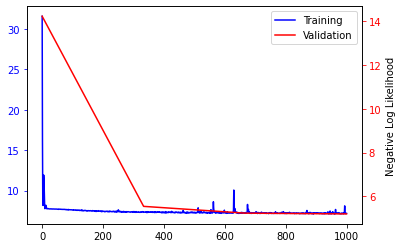

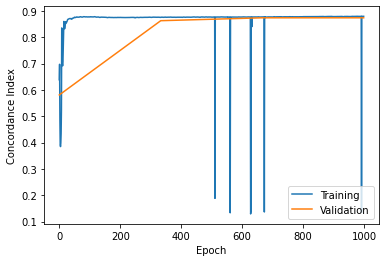

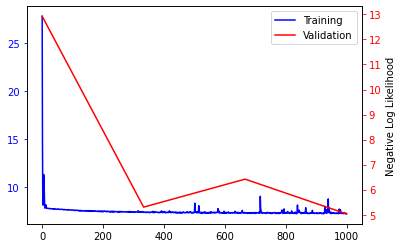

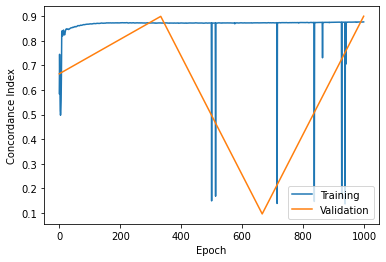

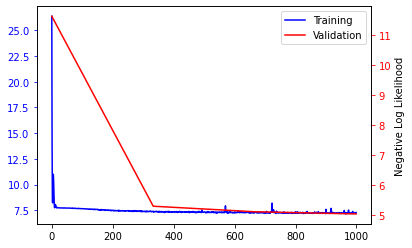

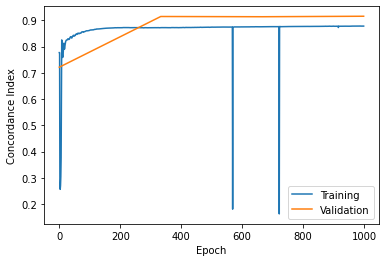

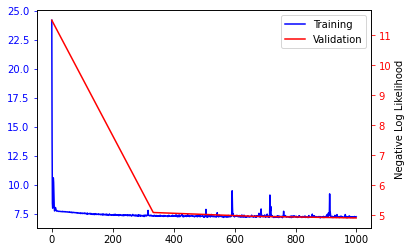

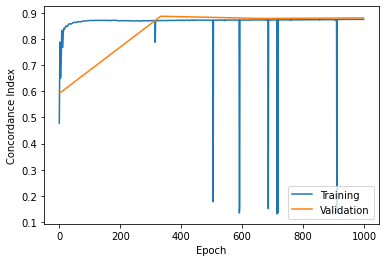

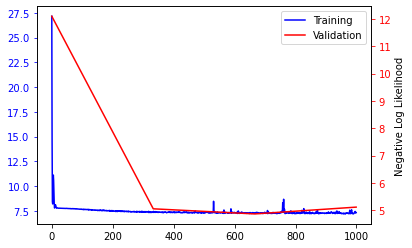

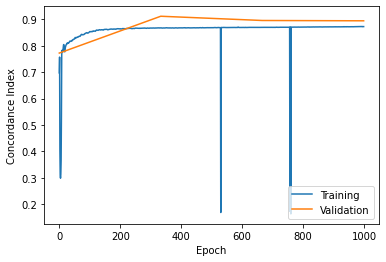

In [9]:
###PRS
c=[]

for i in range(1,6):
    data = LoadData('Total_fs_RS_cv_split_'+str(i))

    train_label_set=data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    columnsname=['TBV','HV','INF','age','PRS']
    mean=train_label_set[columnsname].mean()
    std=train_label_set[columnsname].std()
    train_label_set[columnsname]=(train_label_set[columnsname]-mean)/std
    train_label_set['WMH']=np.log(train_label_set['WMH'])



    validation_label_set=data.validation_label_data
    b=validation_label_set['bigrfullname'].str.decode("utf-8")
    validation_label_set['bigrfullname']=1
    validation_label_set['bigrfullname']=b
    validation_label_set = validation_label_set.set_index('bigrfullname')
    validation_label_set.columns=validation_label_set.columns.str.decode("utf-8")
    validation_label_set['ergoid']=validation_label_set['ergoid'].astype('int')
    
    validation_label_set[columnsname]=(validation_label_set[columnsname]-mean)/std
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])



    train_data = dataframe_to_deepsurv_ds(train_label_set, event_col = 'dementia', time_col= 'event_time')
    valid_data = dataframe_to_deepsurv_ds(validation_label_set, event_col = 'dementia', time_col= 'event_time')
    
    hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-02,
    'lr_decay': 0.1,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
    }
        
    # Create an instance of DeepSurv using the hyperparams defined above
    model = deep_surv.DeepSurv(**hyperparams)

    # DeepSurv can now leverage TensorBoard to monitor training and validation
    # This section of code is optional. If you don't want to use the tensorboard logger
    # Uncomment the below line, and comment out the other three lines: 
    # logger = None
    
    experiment_name='model_PRS_'+str(i)
    logdir = './logs/tensorboard/'
    logger = TensorboardLogger(experiment_name, logdir=logdir)

    # Now we train the model
    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    n_epochs = 1000

    # If you have validation data, you can add it as the second parameter to the function
    metrics = model.train(train_data,valid_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)
    viz.plot_log(metrics)

    test_label_set=data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
    test_label_set[columnsname]=(test_label_set[columnsname]-mean)/std
    test_label_set['WMH']=np.log(test_label_set['WMH'])
    
    test_data = dataframe_to_deepsurv_ds(test_label_set, event_col = 'dementia', time_col= 'event_time')


    ci=model.get_concordance_index(**test_data)
    print(ci)
    c.append(ci)
    
    
    output_file = experiment_name +'_test_predictions.txt'
    with open('../final/'+output_file, "w") as f:
        for element in model.predict_risk(test_data['x']):
            f.write(str(element[0]) + "\n")
    f.close()


Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
2025-08-31 18:05:57,906 - Training step 0/2000    |                         | - loss: 29.3693 - ci: 0.5180
2025-08-31 18:05:57,906 - Training step 0/2000    |                         | - loss: 29.3693 - ci: 0.5180
2025-08-31 18:06:52,133 - Training step 250/2000  |***                      | - loss: 7.7049 - ci: 0.8359
2025-08-31 18:06:52,133 - Training step 250/2000  |***                      | - loss: 7.7049 - ci: 0.8359
2025-08-31 18:07:50,134 - Training step 500/2000  |******                   | - loss: 7.2327 - ci: 0.9121
2025-08-31 18:07:50,134 - Training step 500/2000  |******                   | - loss: 7.2327 - ci: 0.9121
2025-08-31 18:08:49,629 - Training step 750/2000  |*********                | - loss: 6.9902 - ci: 0.9363
2025-08-31 18:08:49,629 - Training step 750/2000  |*********                | - loss: 6.9902 - ci: 0.9363
2025-08-31 18:09:45,280 - Training step 1000/2000 |************    

2025-08-31 18:37:47,414 - Training step 250/2000  |***                      | - loss: 7.7701 - ci: 0.7889
2025-08-31 18:38:44,747 - Training step 500/2000  |******                   | - loss: 7.4439 - ci: 0.8986
2025-08-31 18:38:44,747 - Training step 500/2000  |******                   | - loss: 7.4439 - ci: 0.8986
2025-08-31 18:39:42,728 - Training step 750/2000  |*********                | - loss: 7.0976 - ci: 0.9196
2025-08-31 18:39:42,728 - Training step 750/2000  |*********                | - loss: 7.0976 - ci: 0.9196
2025-08-31 18:40:38,656 - Training step 1000/2000 |************             | - loss: 6.8475 - ci: 0.9556
2025-08-31 18:40:38,656 - Training step 1000/2000 |************             | - loss: 6.8475 - ci: 0.9556
2025-08-31 18:41:39,196 - Training step 1250/2000 |***************          | - loss: 6.4598 - ci: 0.9760
2025-08-31 18:41:39,196 - Training step 1250/2000 |***************          | - loss: 6.4598 - ci: 0.9760
2025-08-31 18:42:39,523 - Training step 1500/2

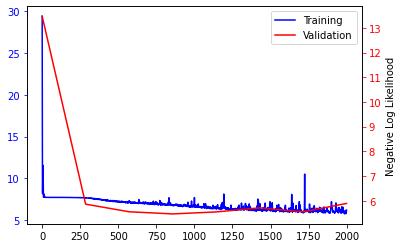

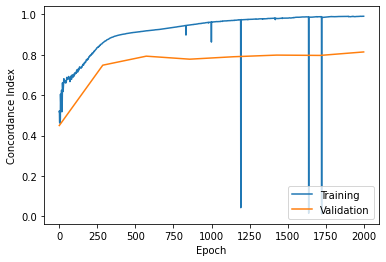

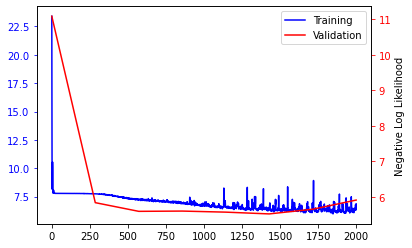

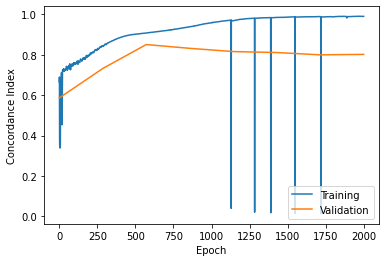

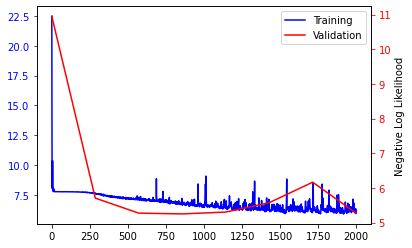

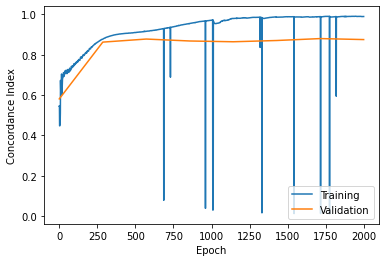

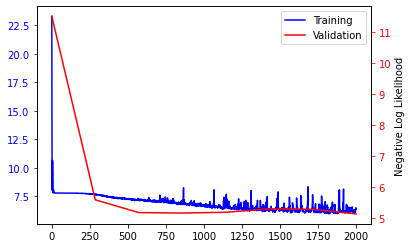

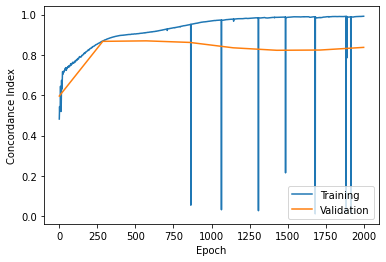

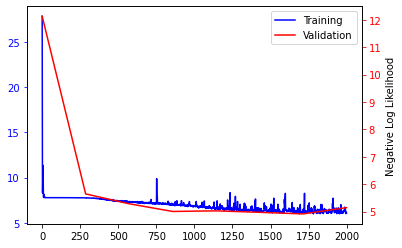

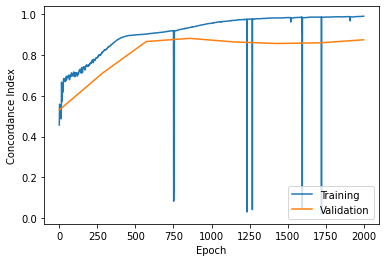

In [13]:
###SNP
c=[]

for i in range(1,6):
    data = LoadData('Total_fs_RS_cv_split_'+str(i))

    train_label_set=data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    columnsname=['TBV','HV','INF','age','PRS']
    mean=train_label_set[columnsname].mean()
    std=train_label_set[columnsname].std()
    train_label_set[columnsname]=(train_label_set[columnsname]-mean)/std
    train_label_set['WMH']=np.log(train_label_set['WMH'])
    train_label_set=train_label_set.iloc[:,:-1]
    
    train_gene_data = data.train_gene_data   
    train_gene_data.columns=train_gene_data.columns.str.decode("utf-8")
    train_gene_data=train_gene_data.drop('rs7157106',axis=1)
    train_label_set = train_label_set.merge(train_gene_data,on='ergoid')


    validation_label_set=data.validation_label_data
    b=validation_label_set['bigrfullname'].str.decode("utf-8")
    validation_label_set['bigrfullname']=1
    validation_label_set['bigrfullname']=b
    validation_label_set = validation_label_set.set_index('bigrfullname')
    validation_label_set.columns=validation_label_set.columns.str.decode("utf-8")
    validation_label_set['ergoid']=validation_label_set['ergoid'].astype('int')
    
    validation_label_set[columnsname]=(validation_label_set[columnsname]-mean)/std
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])
    validation_label_set=validation_label_set.iloc[:,:-1]
    
    validation_gene_data = data.validation_gene_data   
    validation_gene_data.columns=validation_gene_data.columns.str.decode("utf-8")
    validation_gene_data=validation_gene_data.drop('rs7157106',axis=1)
    validation_label_set = validation_label_set.merge(validation_gene_data,on='ergoid')


    train_data = dataframe_to_deepsurv_ds(train_label_set, event_col = 'dementia', time_col= 'event_time')
    valid_data = dataframe_to_deepsurv_ds(validation_label_set, event_col = 'dementia', time_col= 'event_time')
    
    hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-02,
    'lr_decay': 0.01,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
    }
        
    # Create an instance of DeepSurv using the hyperparams defined above
    model = deep_surv.DeepSurv(**hyperparams)

    # DeepSurv can now leverage TensorBoard to monitor training and validation
    # This section of code is optional. If you don't want to use the tensorboard logger
    # Uncomment the below line, and comment out the other three lines: 
    # logger = None
    
    experiment_name='model_SNP_'+str(i)
    logdir = './logs/tensorboard/'
    logger = TensorboardLogger(experiment_name, logdir=logdir)

    # Now we train the model
    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    n_epochs = 2000

    # If you have validation data, you can add it as the second parameter to the function
    metrics = model.train(train_data,valid_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)
    viz.plot_log(metrics)

    test_label_set=data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')

    test_label_set[columnsname]=(test_label_set[columnsname]-mean)/std
    test_label_set['WMH']=np.log(test_label_set['WMH'])
    test_label_set=test_label_set.iloc[:,:-1]
    
    test_gene_data = data.test_gene_data   
    test_gene_data.columns=test_gene_data.columns.str.decode("utf-8")
    test_gene_data=test_gene_data.drop('rs7157106',axis=1)
    test_label_set = test_label_set.merge(test_gene_data,on='ergoid')

    
    test_data = dataframe_to_deepsurv_ds(test_label_set, event_col = 'dementia', time_col= 'event_time')
    

    ci=model.get_concordance_index(**test_data)
    print(ci)
    c.append(ci)
    
    
    output_file = experiment_name +'_test_predictions.txt'
    with open('../final/'+output_file, "w") as f:
        for element in model.predict_risk(test_data['x']):
            f.write(str(element[0]) + "\n")
    f.close()


In [11]:
from lifelines.utils import concordance_index

In [15]:
import scipy.stats as st
model_list=['BM','Gender_Age','Gender_Age_Apoe','PRS','SNP']



for j in model_list:
    c=[]
    for i in range(1,6):
        data = LoadData('Total_fs_RS_cv_split_'+str(i))

        test_label_set=data.test_label_data
        test_label_set = test_label_set.set_index('bigrfullname')
        test_label_set.columns=test_label_set.columns.str.decode("utf-8")

        test_prediction=pd.read_table('../final/model_'+j+'_'+str(i)+'_test_predictions.txt',header=None)[0].tolist()
        test_label_set['prediction']=test_prediction
        test_label_set=test_label_set.drop_duplicates(['ergoid'])
        
        c.append(1-concordance_index(test_label_set.event_time,test_label_set.prediction, test_label_set.dementia))
        
        
    print(c)
    print(np.mean(c))
    ci=tuple(np.round(st.t.interval(0.95, len(c)-1, loc=np.mean(c), scale=st.sem(c)),2))
    print(ci)
    

Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5
[0.8469161887513834, 0.8439212755356253, 0.866275204963439, 0.8591158590568376, 0.8591340111961613]
0.8550725079006893
(0.84, 0.87)
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5
[0.8580843143173358, 0.868522670652715